<a href="https://colab.research.google.com/github/liu-feng116/EvaluateModels/blob/main/slow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.import模块

In [1]:
try:
    import torch
except ModuleNotFoundError:
    !pip install torch torchvision
    import os
    import sys
    import torch
    
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorchvideo
else:
    need_pytorchvideo=False
    try:
        # Running notebook locally
        import pytorchvideo
    except ModuleNotFoundError:
        need_pytorchvideo=True
    if need_pytorchvideo:
        # Install from GitHub
        !pip install "git+https://github.com/facebookresearch/pytorchvideo.git"

import json 
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 
from typing import Dict

  Cloning https://github.com/facebookresearch/pytorchvideo.git to /tmp/pip-req-build-ps3ywun9
  Running command git clone -q https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-ps3ywun9
     |████████████████████████████████| 49 kB 2.5 MB/s 
     |████████████████████████████████| 37.2 MB 31 kB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.3-py3-none-any.whl size=187960 sha256=0f1481d90786e14722898ae440c7e467714e5fb67f7697f09745d3423b7b56d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-8oe3nnls/wheels/87/af/3d/0f80973f39ae2239c1ee9496b333ef4e90bf2d80d486b50eca
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=18725bc5d6d5d692632b87518cd7c1e2b6a17435e1e124a99cb2854da28c40fa
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built pytorchvideo fvcore
  Attempting uninstall: p

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  "The _functional_video module is deprecated. Please use the functional module instead."
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  "The _transforms_video module is deprecated. Please use the transforms module instead."


2.下载测试数据集

In [2]:
!wget https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
with open("kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# 对数据集标签进行处理
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

--2021-11-07 16:29:20--  https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10326 (10K) [text/plain]
Saving to: ‘kinetics_classnames.json’

kinetics_classnames 100%[===================>]  10.08K  --.-KB/s    in 0s      

2021-11-07 16:29:21 (55.7 MB/s) - ‘kinetics_classnames.json’ saved [10326/10326]



3.利用Torch Hub加载预处理模型，这里选择根据tutorial先测试slowfast

In [3]:
def get_model(device, model_name):
  # 从torch hub导入model
  model = torch.hub.load("facebookresearch/pytorchvideo:main", model=model_name, pretrained=True)
  # 设置eval（测试），设置设备
  model = model.to(device)
  model = model.eval()
  return model

4.设置输入变换（input transformation）。备注：tutorial写到不同模型的输入处理不同，此处针对slowfast。

In [4]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 8
sampling_rate = 8
frames_per_second = 30

# Note that this transform is specific to the slow_R50 model.
transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size=(crop_size, crop_size))
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

5.加载example video

In [5]:
# 下载example video
!wget https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4

--2021-11-07 16:29:21--  https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549197 (536K) [video/mp4]
Saving to: ‘archery.mp4’

archery.mp4         100%[===================>] 536.33K  1.70MB/s    in 0.3s    

2021-11-07 16:29:21 (1.70 MB/s) - ‘archery.mp4’ saved [549197/549197]



In [6]:
# 对视频进行切片处理
def clip(video_path, start_sec, clip_duration, device):
  # 选择要加载的切片的持续时间。
  end_sec = start_sec + clip_duration 
  # 初始化EncodeVideo类
  video = EncodedVideo.from_path(video_path)
  # 加载所需的切片数据
  video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
  # 应用此前设置的输入变换处理切片数据
  video_data = transform(video_data)
  # 将切片数据加载到cpu内存
  inputs = video_data["video"]
  inputs = inputs.to(device)
  return inputs

6.进行prediction

In [7]:
import time
# 向model导入切片数据
inputs = clip("archery.mp4", 0, clip_duration, "cpu")
model_list = ["slow_r50"]
time_list = []
mean_time = 0.0
for model_name in model_list:
  print("-----------------------")
  print("The model of %s is running:" % model_name)
  # 开始预测
  for i in range(10):
    inputs = clip("archery.mp4", 0, clip_duration, "cpu")
    model = get_model("cpu", model_name)

    # 开始计时
    start = time.clock()

    preds = model(inputs[None, ...])

    # 结束计时
    end = time.clock()

    # 累计求和
    mean_time = mean_time + (end - start)

    # 获得预测类别
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=5).indices
    print(pred_classes)

    # 通过kineticss_id_to_classname获取对应indices的label
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    print("%d round:" % i )
    print("Predicted labels: %s" % ", ".join(pred_class_names))
  
  # 平均
  mean_time = mean_time/10
  time_list.append(mean_time)
  print('time: %e' % mean_time)

-----------------------
The model of slow_r50 is running:


Downloading: "https://github.com/facebookresearch/pytorchvideo/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOW_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOW_8x8_R50.pyth


  0%|          | 0.00/248M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
0 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse
tensor([[  5, 356, 240, 333, 273]])
1 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
2 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
3 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
4 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
5 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
6 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
7 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
8 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


tensor([[  5, 356, 240, 333, 273]])
9 round:
Predicted labels: archery, throwing axe, playing paintball, stretching arm, riding or walking with horse
time: 2.730265e+00


7.绘制图像

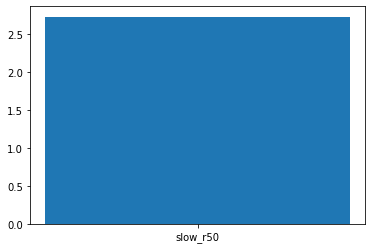

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(model_list, time_list, width=[0.1])
plt.show()